<a href="https://colab.research.google.com/github/agemagician/ProtTrans/blob/master/Embedding/Onnx/ProtBert-BFD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Important Notes:**

1. The current onnx implementation only works correctly with a single sequence per batch.
2. It will work with many sequences per batch, but the results will be different from the original pytorch implementation.
3. We will update the notebook if we figured out the problem.
4. Pytorch FP16 is much faster than Pytorch FP32 when more sequences per batch is used.

**Check GPU**

In [1]:
!nvidia-smi

Wed Nov 18 21:52:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Install libraries**

In [2]:
!pip install -q transformers
!pip install -q biopython
!pip install -q onnxruntime-gpu==1.4.0
!pip install -q onnxruntime-tools==1.4.2

     |████████████████████████████████| 1.3MB 12.4MB/s 
     |████████████████████████████████| 890kB 55.8MB/s 
     |████████████████████████████████| 1.1MB 28.6MB/s 
     |████████████████████████████████| 2.9MB 57.4MB/s 
     |████████████████████████████████| 2.3MB 13.9MB/s 
     |████████████████████████████████| 25.4MB 1.5MB/s 
     |████████████████████████████████| 143kB 13.0MB/s 
     |████████████████████████████████| 102kB 9.7MB/s 
     |████████████████████████████████| 7.7MB 21.9MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 92kB 12.5MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp36-none-any.whl size=20071 sha256=7abab0f8ff8098a4b378fc611c783f3e8589a1916cf3f81ea929d10d0fd48461
  Stored in directory: /root/.cache/pip/wheels/f1/93/7b/127daf0c3a5a49feb2fecd468d508067c733fba5192f726ad1
Successfully built py-cpuinfo


**Import libraries**

In [3]:
import torch
from transformers import BertModel, BertTokenizer, pipeline
from pathlib import Path
from transformers.convert_graph_to_onnx import convert

import numpy as np
import os
from tqdm.auto import tqdm
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re

from contextlib import contextmanager
from dataclasses import dataclass
from time import time
from tqdm import trange

from os import environ
from psutil import cpu_count

# optimize transformer-based models with onnxruntime-tools
from onnxruntime_tools import optimizer
# This is optional if you need more optimization for bert based models
from onnxruntime_tools.transformers.onnx_model_bert import BertOptimizationOptions
from onnxruntime import GraphOptimizationLevel, InferenceSession, SessionOptions, get_all_providers

In [4]:
%matplotlib inline

**Create Some Data**

In [5]:
proteins = ["VKAPHEHEHEDNPSVSRVFNRLSQARQNARSIIWGGDGELLTGLIRMVLQVTSPDDKKLSQRDEDGPRLNNCIFTIGFLVPYISEKLKALVTLEVGKPAWTAGDRRKVMGHCADEQIRLILTCAFVGYHTAYKEKFTSEAGSELMGLAFDKYDESYTVEMKKITPFGSSRLVIVLLQFNMQADNAPANAPLAVQSIYGIT",
                 "TYGASGLERPGYIIDSAQLSLRYGADADRAARFPNISAMRVGTLCTLGSLPKQTTNPINFQKIVDSGAPKDDGDGWERKWLTGCIANPYTILGTPTSGEGKDQRPQDGSRVNISEHLQTV PAAVQSQGESWEVGEEMKLKRESIIRVQPELTLSILGDKQARTLPAHSMKKSLEPAARVIMNLLPRRHEKVFCEPTDRRAQELIELAMERNNYDMLELSPHAPDTPRLAVEEAVAAINARLAFVGLGDRGNESGLFYVVDKGDKFDDEYSSYINIVGIQKLWKGSEVLKWVSGVGSMTHNEIRPGTCCNEPQDMFIQELVHLTTLFNGTVRGGVKDFKSLTFSALLEAEAVSAKSIFTRLRLHMKIYLYNISHDHFSADVLDQYKLGFAAEYKHRAALPENKKLTLDLYSAFFSTEPQSIGANIVMEASKGQVPITTMLIINKRISVLGAALALQVELKNFYNNRLRVFDQGEYPCAKLKVLWFTMEHHGCDIFVKVFVTAPDVQDEVAIVS",
                 "PSKSLKCTGGNAFALRFIRQDDAEVAPLGVSEIWLNDIGMKHELYQTVRT",
                 "IKNEIVHTVFSTLQPRDHLNGLRLQIEEATCDALRVPLGAGGLVAEEVSKKRPALYDANYFEDVLKTAGIFSPRVSGRADMEKQGFNPKMTSLQSYWSII"]

In [6]:
proteins = [" ".join(list(item)) for item in proteins]

In [7]:
proteins = [re.sub(r"[UZOB]", "X", sequence) for sequence in proteins]

**Import Tokenizer**

In [9]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)

**Convert pytorch to onnx**

In [10]:
!rm -rf onnx/
# Handles all the above steps for you
convert(framework="pt",
        model="Rostlab/prot_bert_bfd",
        output=Path("onnx/prot_bert_bfd.onnx"),
        opset=12,
        tokenizer="Rostlab/prot_bert_bfd")

ONNX opset version set to: 12
Loading pipeline (model: Rostlab/prot_bert_bfd, tokenizer: Rostlab/prot_bert_bfd)



Creating folder onnx
Using framework PyTorch: 1.7.0+cu101
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input token_type_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch', 1: 'sequence'}
Found output output_1 with shape: {0: 'batch'}
Ensuring inputs are in correct order
position_ids is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask', 'token_type_ids']


/usr/local/lib/python3.6/dist-packages/transformers/modeling_bert.py:191: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  position_ids = self.position_ids[:, :seq_length]
/usr/local/lib/python3.6/dist-packages/transformers/modeling_utils.py:1673: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  input_tensor.shape == tensor_shape for input_tensor in input_tensors


**Optimize onnx model**

In [11]:
# disable embedding layer norm optimization for better model size reduction
opt_options = BertOptimizationOptions('bert')
opt_options.enable_embed_layer_norm = False

opt_model = optimizer.optimize_model(
    'onnx/prot_bert_bfd.onnx',
    'bert', 
    num_heads=16,
    hidden_size=1024,
    optimization_options=opt_options)
# This is optional if you need to run the model using mixed precisionn
opt_model.convert_model_float32_to_float16()

opt_model.save_model_to_file('onnx/prot_bert_bfd.opt.onnx')

**Embed with onnx**

In [67]:
inference_time = {"Pytorch FP32":0,"Pytorch FP16":0, "Onnx FP16":0}

In [68]:
# Constants from the performance optimization available in onnxruntime
# It needs to be done before importing onnxruntime
environ["OMP_NUM_THREADS"] = str(cpu_count(logical=True))
environ["OMP_WAIT_POLICY"] = 'ACTIVE'

In [69]:
def create_model_for_provider(model_path: str, provider: str) -> InferenceSession: 
  
  assert provider in get_all_providers(), f"provider {provider} not found, {get_all_providers()}"

  # Few properties that might have an impact on performances (provided by MS)
  options = SessionOptions()
  options.intra_op_num_threads = 1
  options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL

  # Load the model as a graph and prepare the CPU backend 
  session = InferenceSession(model_path, options, providers=[provider])
  session.disable_fallback()
    
  return session


@contextmanager
def track_infer_time(buffer: [int]):
    start = time()
    yield
    end = time()

    buffer.append(end - start)


@dataclass
class OnnxInferenceResult:
  model_inference_time: [int]  
  optimized_model_path: str

In [70]:
gpu_model = create_model_for_provider('/content/onnx/prot_bert_bfd.opt.onnx', "CUDAExecutionProvider")

In [71]:
totalDuration = 0

for itr in range(50):
  for batch in proteins:
    maxLen = len(max(batch, key=len))/2
    minLen = len(min(batch, key=len))/2
    batch_size = len(batch)

    time1 = time()

    # Inputs are provided through numpy array
    model_inputs = tokenizer(batch, return_tensors="pt", padding=True, add_special_tokens=True)
    inputs_onnx = {k: v.cpu().detach().numpy() for k, v in model_inputs.items()}

    # Run the model (None = get all the outputs)
    onnx_embedding, onnx_pooled = gpu_model.run(None, inputs_onnx)

    #embedding = model(batch)
    time2 = time()

    duration = time2-time1
    totalDuration += duration
    print('{:s} model took {:.3f} ms for sequence length between {:.3f} and {:3f} of total sequences {:d}'.format('ProtBert-BFD', duration*1000.0,minLen,maxLen,batch_size))

inference_time["Onnx FP16"] = totalDuration*1000.0
print('Total duration is {:.3f}'.format(totalDuration*1000.0))

ProtBert-BFD model took 13.136 ms for sequence length between 0.500 and 0.500000 of total sequences 399
ProtBert-BFD model took 25.217 ms for sequence length between 0.500 and 0.500000 of total sequences 1025
ProtBert-BFD model took 6.183 ms for sequence length between 0.500 and 0.500000 of total sequences 99
ProtBert-BFD model took 7.200 ms for sequence length between 0.500 and 0.500000 of total sequences 199
ProtBert-BFD model took 9.950 ms for sequence length between 0.500 and 0.500000 of total sequences 399
ProtBert-BFD model took 22.419 ms for sequence length between 0.500 and 0.500000 of total sequences 1025
ProtBert-BFD model took 5.861 ms for sequence length between 0.500 and 0.500000 of total sequences 99
ProtBert-BFD model took 6.861 ms for sequence length between 0.500 and 0.500000 of total sequences 199
ProtBert-BFD model took 10.051 ms for sequence length between 0.500 and 0.500000 of total sequences 399
ProtBert-BFD model took 22.913 ms for sequence length between 0.500 a

**Embed with pytorch**

In [72]:
model = BertModel.from_pretrained("Rostlab/prot_bert_bfd")

In [73]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [74]:
model = model.to(device)
model = model.eval()

In [75]:
totalDuration = 0

for itr in range(50):
  for batch in proteins:
    #batch = list_part[0]
    maxLen = len(max(batch, key=len))/2
    minLen = len(min(batch, key=len))/2
    batch_size = len(batch)

    time1 = time()

    #ids = tokenizer.encode_plus(batch, return_tensors="pt", add_special_tokens=False, pad_to_max_length=True)
    ids = tokenizer(batch, return_tensors="pt", padding=True, add_special_tokens=True)
    input_ids = torch.tensor(ids['input_ids']).to(device)
    with torch.no_grad():
      pytorch_embedding, pytorch_pool = model(input_ids=input_ids)

    #embedding = model(batch)
    time2 = time()

    duration = time2-time1
    totalDuration += duration
    print('{:s} model took {:.3f} ms for sequence length between {:.3f} and {:3f} of total sequences {:d}'.format('ProtBert-BFD', duration*1000.0,minLen,maxLen,batch_size))

inference_time["Pytorch FP32"] = totalDuration*1000.0
print('Total duration is {:.3f}'.format(totalDuration*1000.0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


ProtBert-BFD model took 35.942 ms for sequence length between 0.500 and 0.500000 of total sequences 399
ProtBert-BFD model took 39.580 ms for sequence length between 0.500 and 0.500000 of total sequences 1025
ProtBert-BFD model took 50.407 ms for sequence length between 0.500 and 0.500000 of total sequences 99
ProtBert-BFD model took 35.005 ms for sequence length between 0.500 and 0.500000 of total sequences 199
ProtBert-BFD model took 36.307 ms for sequence length between 0.500 and 0.500000 of total sequences 399
ProtBert-BFD model took 36.634 ms for sequence length between 0.500 and 0.500000 of total sequences 1025
ProtBert-BFD model took 47.833 ms for sequence length between 0.500 and 0.500000 of total sequences 99
ProtBert-BFD model took 29.729 ms for sequence length between 0.500 and 0.500000 of total sequences 199
ProtBert-BFD model took 31.626 ms for sequence length between 0.500 and 0.500000 of total sequences 399
ProtBert-BFD model took 33.522 ms for sequence length between 0.

In [76]:
model_half = model.half()

In [77]:
totalDuration = 0

for itr in range(50):
  for batch in proteins:
    #batch = list_part[0]
    maxLen = len(max(batch, key=len))/2
    minLen = len(min(batch, key=len))/2
    batch_size = len(batch)

    time1 = time()

    #ids = tokenizer.encode_plus(batch, return_tensors="pt", add_special_tokens=False, pad_to_max_length=True)
    ids = tokenizer(batch, return_tensors="pt", padding=True, add_special_tokens=True)
    input_ids = torch.tensor(ids['input_ids']).to(device)
    with torch.no_grad():
      pytorch_embedding_half, pytorch_pool_half = model_half(input_ids=input_ids)

    #embedding = model(batch)
    time2 = time()

    duration = time2-time1
    totalDuration += duration
    print('{:s} model took {:.3f} ms for sequence length between {:.3f} and {:3f} of total sequences {:d}'.format('ProtBert-BFD', duration*1000.0,minLen,maxLen,batch_size))

inference_time["Pytorch FP16"] = totalDuration*1000.0
print('Total duration is {:.3f}'.format(totalDuration*1000.0))

ProtBert-BFD model took 36.103 ms for sequence length between 0.500 and 0.500000 of total sequences 399
ProtBert-BFD model took 34.940 ms for sequence length between 0.500 and 0.500000 of total sequences 1025
ProtBert-BFD model took 31.531 ms for sequence length between 0.500 and 0.500000 of total sequences 99


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


ProtBert-BFD model took 33.623 ms for sequence length between 0.500 and 0.500000 of total sequences 199
ProtBert-BFD model took 32.002 ms for sequence length between 0.500 and 0.500000 of total sequences 399
ProtBert-BFD model took 35.502 ms for sequence length between 0.500 and 0.500000 of total sequences 1025
ProtBert-BFD model took 32.243 ms for sequence length between 0.500 and 0.500000 of total sequences 99
ProtBert-BFD model took 35.491 ms for sequence length between 0.500 and 0.500000 of total sequences 199
ProtBert-BFD model took 32.760 ms for sequence length between 0.500 and 0.500000 of total sequences 399
ProtBert-BFD model took 35.886 ms for sequence length between 0.500 and 0.500000 of total sequences 1025
ProtBert-BFD model took 32.575 ms for sequence length between 0.500 and 0.500000 of total sequences 99
ProtBert-BFD model took 31.060 ms for sequence length between 0.500 and 0.500000 of total sequences 199
ProtBert-BFD model took 31.951 ms for sequence length between 0.

**Compare Inference Performance**

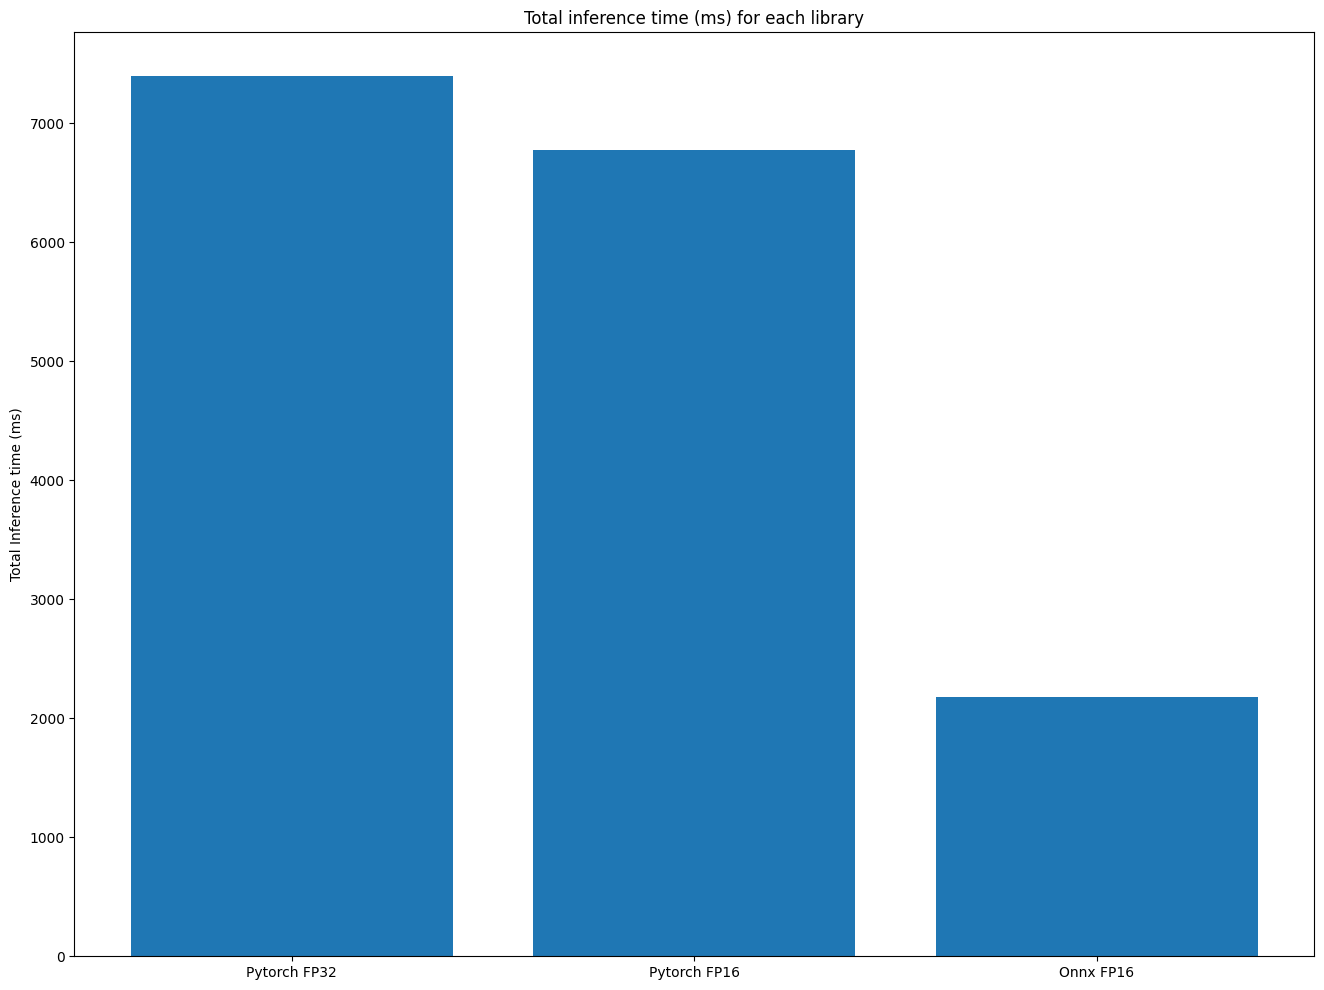

In [95]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_ylabel("Total Inference time (ms)")
ax.set_title("Total inference time (ms) for each library")
ax.bar(inference_time.keys(), inference_time.values())#, yerr=time_results_std)
plt.show()

**Compare output**

In [92]:
diff_fp32 = 0
diff_fp16 = 0
total = 0

for seq in range(pytorch_embedding.shape[0]):
  for token in range(pytorch_embedding.shape[1]):
    for feature in range(pytorch_embedding.shape[2]):
      diff_fp32 += abs(abs(pytorch_embedding[seq][token][feature]) - abs(onnx_embedding[seq][token][feature]))
      diff_fp16 += abs(abs(pytorch_embedding_half[seq][token][feature]) - abs(onnx_embedding[seq][token][feature]))
      total += 1

avg_fp32 = diff_fp32 / total
avg_fp16 = diff_fp16 / total

In [94]:
print("Average difference between pytorch fp32 embedding and onnx embedding = {0}".format(avg_fp32))
print("Average difference between pytorch fp16 embedding and onnx embedding = {0}".format(avg_fp16))

Average difference between pytorch fp32 embedding and onnx embedding = 0.0004189802275504917
Average difference between pytorch fp16 embedding and onnx embedding = 6.300210952758789e-05
